# Titanic notebook

The purpose of this notebook is to study the titanic dataset and select relevant features in order to predict whether someone survived the shipwreck.

This notebook will use functions from the _titanic module to preprocess the data.

### Module and data import

In [ ]:
# Adding relative path for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import numpy as np
import _titanic

 ### First look at the data

In [ ]:
train = pd.read_csv('../_data/titanic_train.csv')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As you can see above, the dataset has 11 features and the target feature "Survived". The 11 features are as following :
 - `PassengerId` : an ID ranging from one to the number of passengers
 - `Pclass` : the ticket class
 - `Name` : the name of the passenger
 - `Sex` : the sex of the passenger
 - `Age` : the age in years
 - `SibSp` : the number of siblings/spouses aboard the Titanic
 - `Parch` : the number of parents/children aboard the Titanic
 - `Ticket` : the ticket number
 - `Fare` : the price of the ticker
 - `Cabin` : the cabin number
 - `Embarked` : the port of embarkation

### Creating Models

We can have a first prediction using three of the features : `SibSp`, `Parch`, `Fare`. Indeed, for the first two features, we can assume that the more family relations a passenger had in the ship, the more likely they were to survive. For the last feature, we can assume that the more expensive the ticket, the wealthier the passenger and the higher the probability of them to survive.

In [ ]:
model1_cols = ['SibSp', 'Parch', 'Fare']
X, y = _titanic.parse_model(train.copy(), name_Y='Survived', use_columns=model1_cols)

In [ ]:
_titanic.logmodel_prediction(X, y, 0.3, 42)

              precision    recall  f1-score   support

           0       0.65      0.94      0.77       157
           1       0.76      0.28      0.41       111

    accuracy                           0.66       268
   macro avg       0.70      0.61      0.59       268
weighted avg       0.69      0.66      0.62       268

score : 0.664179104477612


This prediction is far from accurate, but it is a first model upon which we can add features.

In order to choose other features, one method is to use a correlation matrix to see which feature is correlated to survival.

&lt;AxesSubplot:&gt;

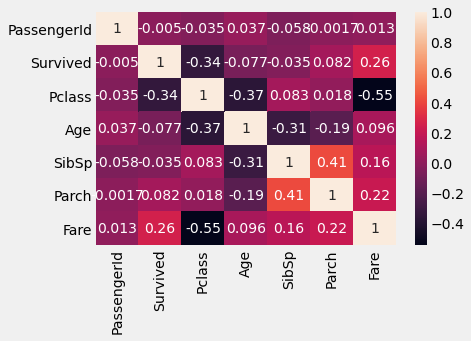

In [ ]:
import seaborn as sn
sn.heatmap(train.corr(), annot=True)

Among the feature not yet selected, the two features with the highest absolute correlation value are `Pclass` and `Age`.

Let us study these two features and the impact they have on our current model.

In [ ]:
dead = train[train['Survived']==0]
survived = train[train['Survived']==1]

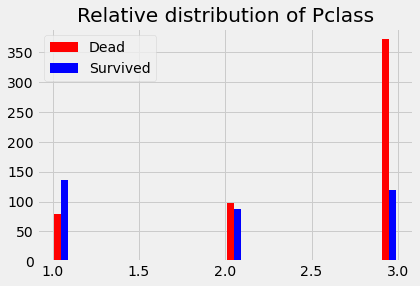

In [ ]:
_titanic.plot_hist('Pclass', 'Dead', 'Survived', dead, survived)

As seen with the previous plot, the `Pclass` feature has a great impact on whether someone will survive. Indeed, people in the first Pclass are more likely to survive than people in the third Pclass.

Thus, we add `Pclass` in our model.

In [ ]:
model2 = train[model1_cols+['Survived', 'Pclass']]
model2_cols = model1_cols + ['Pclass']
X2, y2 = _titanic.parse_model(model2, name_Y='Survived', use_columns=model2_cols)

In [ ]:
_titanic.logmodel_prediction(X2, y2, 0.3, 101)

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       154
           1       0.67      0.43      0.52       114

    accuracy                           0.67       268
   macro avg       0.67      0.64      0.63       268
weighted avg       0.67      0.67      0.65       268

score : 0.667910447761194


Adding the `Pclass` feature only slightly increase the score.

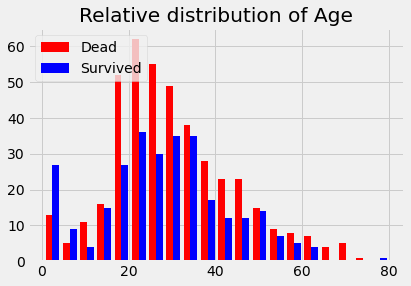

In [ ]:
_titanic.plot_hist('Age', 'Dead', 'Survived', dead, survived)

Firstly, we check whether there are void values.

In [ ]:
total = train['Age'].isnull().sum()
percent_1 = train['Age'].isnull().sum()/train['Age'].isnull().count()*100
print(percent_1)

19.865319865319865


Since approximately a fifth of the values are null, the first step to use the `Age` feature is to fill these values.

As seen in the correlation map, age is most correlated with `Pclass`. Thus, we fille the missing `Age` values with the median age value of each `Pclass`.

In [ ]:
train2 = train.copy()
_titanic.fill_with_median(train2, 'Age', 'Pclass')
train2['Age'] = train2['Age'].astype('int')

We can now add the `Age` feature to the model.

In [ ]:
model3_cols = model2_cols+['Age']
model3 = model2.join(train2['Age'])
X3, y3 = _titanic.parse_model(model3, name_Y="Survived", use_columns=model3_cols)
_titanic.logmodel_prediction(X3, y3, 0.3, 42)

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       157
           1       0.77      0.48      0.59       111

    accuracy                           0.72       268
   macro avg       0.74      0.69      0.69       268
weighted avg       0.73      0.72      0.71       268

score : 0.7238805970149254


Adding both features hightened significantly the score. However, in the relative distribution of the `Age` feature, one can see age categories would be more appropriate than simply leaving the age.

In [ ]:
ageCat = pd.Series(_titanic.div_cat(train2['Age'], 5), name="ageCat")
model4 = model2.join(ageCat)
model4_cols = model2_cols + ['ageCat']
X4, y4 = _titanic.parse_model(model4, name_Y="Survived", use_columns=model4_cols)
_titanic.logmodel_prediction(X4, y4, 0.3, 101)

              precision    recall  f1-score   support

           0       0.69      0.86      0.76       154
           1       0.72      0.46      0.56       114

    accuracy                           0.69       268
   macro avg       0.70      0.66      0.66       268
weighted avg       0.70      0.69      0.68       268

score : 0.6940298507462687


Another supposition is that the sex of a passenger had an impact on whether they survived. Women would have been saved more frequently than men. Let us check this assumption.

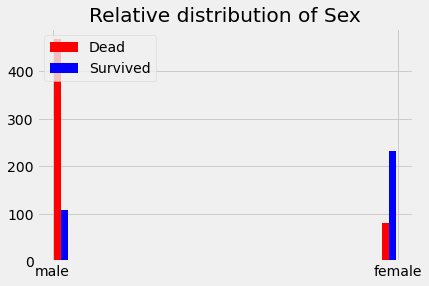

In [ ]:
_titanic.plot_hist('Sex', 'Dead', 'Survived', dead, survived)

Considering the disparity of proportion of survivors in the two sexes, the feature will be added to the model.

However, the current `Sex` feature is not in numerical value. We must create a feature `is_male` with value 0 if the passenger is female and 1 if male.

In [ ]:
is_male = pd.get_dummies(train2['Sex'],drop_first=True)
model5 = model4.join(is_male)
model5_cols = model4_cols + ['male']
X5, y5 = _titanic.parse_model(model5, name_Y="Survived", use_columns=model5_cols)
_titanic.logmodel_prediction(X5, y5, 0.3, 101)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       154
           1       0.77      0.65      0.70       114

    accuracy                           0.77       268
   macro avg       0.77      0.75      0.76       268
weighted avg       0.77      0.77      0.77       268

score : 0.7686567164179104


Among the remaining unused features, let us check the `Name` feature, and more particularly, the title of each person.

In [ ]:
titles = []
for i in range(len(train2)):
    titles.append(train['Name'][i].split(',')[1].split('.')[0].strip())
titles = np.array(titles)
np.unique(titles)

array([&#39;Capt&#39;, &#39;Col&#39;, &#39;Don&#39;, &#39;Dr&#39;, &#39;Jonkheer&#39;, &#39;Lady&#39;, &#39;Major&#39;, &#39;Master&#39;,
       &#39;Miss&#39;, &#39;Mlle&#39;, &#39;Mme&#39;, &#39;Mr&#39;, &#39;Mrs&#39;, &#39;Ms&#39;, &#39;Rev&#39;, &#39;Sir&#39;,
       &#39;the Countess&#39;], dtype=&#39;&lt;U12&#39;)

According to these titles, we can assume passengers with titles "Dr", "Master", or "the Countess" are more likely to be saved because were dimmed more important.

In [ ]:
important = np.zeros(len(train))
for i in range(len(train2)):
    name = train2['Name'][i]
    title = name.split(',')[1].split('.')[0].strip()
    if title=='Dr' or title=='Master' or title=='the Countess':
        important[i] = 1
is_important = pd.Series(important, name='is_important')
model6 = model5.join(is_important)
model6_cols = model5_cols + ['is_important']
X6, y6 = _titanic.parse_model(model6, name_Y="Survived", use_columns=model6_cols)
_titanic.logmodel_prediction(X6, y6, 0.3, 102)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       167
           1       0.80      0.78      0.79       101

    accuracy                           0.84       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268

score : 0.8432835820895522


### Comparing logistic regression to random forest resulsts

In [ ]:
_titanic.random_forest_prediction(X6, y6, 0.3, 404, 100)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       153
           1       0.80      0.70      0.75       115

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

score:  0.7985074626865671


In [ ]:
_titanic.RFE_predicion(X6, y6, 0.3, 101, 8)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       154
           1       0.78      0.73      0.75       114

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268

score:  0.7947761194029851


In [ ]:
_titanic.GSCV_prediction(X6, y6, 0.3, 64)

Parameters chosen:  {&#39;max_depth&#39;: 8, &#39;min_samples_leaf&#39;: 5, &#39;min_samples_split&#39;: 10, &#39;n_estimators&#39;: 150}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       165
           1       0.87      0.67      0.76       103

    accuracy                           0.84       268
   macro avg       0.85      0.80      0.82       268
weighted avg       0.84      0.84      0.83       268

score:  0.835820895522388


In [ ]:
embark = pd.get_dummies(train2['Embarked'])
model7 = model6.join(embark)
model7_cols = model6_cols+['C', 'Q', 'S']
X7, y7 = _titanic.parse_model(model7, name_Y="Survived", use_columns=model7_cols)
_titanic.logmodel_prediction(X7, y7, 0.3, 102)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       167
           1       0.80      0.77      0.78       101

    accuracy                           0.84       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268

score : 0.8395522388059702


In [ ]:
_titanic.GSCV_prediction(X7, y7, 0.3, 64)

Parameters chosen:  {&#39;max_depth&#39;: 10, &#39;min_samples_leaf&#39;: 5, &#39;min_samples_split&#39;: 10, &#39;n_estimators&#39;: 100}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       165
           1       0.88      0.71      0.78       103

    accuracy                           0.85       268
   macro avg       0.86      0.82      0.84       268
weighted avg       0.85      0.85      0.85       268

score:  0.8507462686567164


After numerous tries, during which we tried to dummify the selected features and adding others, we were unable to achieve a higher score.

### Conclusion

The study of this dataset allowed us to choose features in order to predict the survival of a passenger.

In this study, the following features were chosen : 
 - `SibSp`
 - `Parch`
 - `Fare`
 - `Pclass`
 - `Age`
 - `Sex`
 - `Name`
 - `Embark`

Among these features, we dummified the features of `Sex` and `Embark` and we created categories for the features `Age` and `Name`.

Our study lead to a prediction with a score of 85%.